**#Video Processing - Static video**
In a real time envo, the continuous footage will be processed in the same fashion with multithreading to improve inference time.

# Clearing Output dir for testing  

In [18]:
import os
import shutil

# Path to Kaggle working directory
working_dir = '/kaggle/working'

# Loop through all files and folders in the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    
    try:
        # Remove files and folders
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # delete file or symbolic link
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # delete directory
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("✅ Working directory cleaned.")


✅ Working directory cleaned.


# Test run for Video extraction - (Implemented in the next module)

In [1]:
import cv2
import os
import csv
from datetime import datetime, timedelta
import random

def process_video_with_telemetry(video_path, output_folder="output_data"):
    # Create folders
    os.makedirs(output_folder, exist_ok=True)
    frame_folder = os.path.join(output_folder, "frames")
    os.makedirs(frame_folder, exist_ok=True)

    # Video capture setup
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Set up synthetic telemetry start point
    lat, lon, alt = 28.6139, 77.2090, 12.0  # Starting point: New Delhi
    start_time = datetime.now()

    telemetry_data = []

    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        timestamp = start_time + timedelta(seconds=frame_id / fps)

        # Slight random walk to simulate telemetry change
        lat += random.uniform(-0.0001, 0.0001)
        lon += random.uniform(-0.0001, 0.0001)
        alt = 12.0 + random.uniform(-0.5, 0.5)  # minor altitude jitter

        # Save frame
        frame_filename = f"frame_{frame_id:05d}.jpg"
        frame_path = os.path.join(frame_folder, frame_filename)
        cv2.imwrite(frame_path, frame)

        # Save telemetry data
        telemetry_data.append({
            "frame_id": frame_id,
            "frame_file": frame_filename,
            "timestamp": timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            "latitude": round(lat, 6),
            "longitude": round(lon, 6),
            "altitude": round(alt, 2)
        })

        frame_id += 1

    cap.release()

    # Save telemetry data to CSV
    csv_path = os.path.join(output_folder, "telemetry_log.csv")
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=telemetry_data[0].keys())
        writer.writeheader()
        writer.writerows(telemetry_data)

    print(f"[✅] Processed {frame_id} frames.")
    print(f"[📁] Frames saved to: {frame_folder}")
    print(f"[📄] Telemetry CSV saved to: {csv_path}")


In [16]:
Video = "/kaggle/input/parking-video/vecteezy_a-parking-lot-showing-organized-parking-spaces-for-cars-and_49694434.mp4"
process_video_with_telemetry(Video)

[✅] Processed 593 frames.
[📁] Frames saved to: output_data/frames
[📄] Telemetry CSV saved to: output_data/telemetry_log.csv


 ###   Installing dependencies for object detection

In [4]:
!pip install ultralytics --quiet
!pip install transformers --quiet
!pip install opencv-python-headless --quiet

# Object Detection + Image Captioning (frame wise --> Event Club) --> Event Mapping --> Object focused Captioning --> Sematic Embedding --> Event Logging [Processing time @CPU]

Approach - Captioning Individual image to extract all the necessary information : issue - noisy data and irregular captioning. 
event caption example - 'a car is seen in this image from the video, a car is shown through a bubble, a man is sitting on a bench with a laptop, a police car is seen in this und - toned image, a car is seen in this und - toned image, a large building with many tables and chairs, a car is flying through the air, a white car is seen in this surveillance image, a white car driving down a street, a white car is shown in this image, a car is parked on the side of the road, a black diamond'

Issue Fix : Switched to a Video model (currently using BLIP (especially BLIP-1) is optimized for scene captioning, not action/event summarization.) BLIP-2 with conversation-based prompting
    Use YOLOv8 + tracking
    Cluster/collate captions per event

In [15]:
import os
import cv2
import json
import torch
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from torchvision import transforms
from PIL import Image

# Directories
FRAME_DIR = "video_frames"
EVENT_LOG_FILE = "event_logs.jsonl"
EMBEDDING_FILE = "event_embeddings.jsonl"

# Load models
print("Loading models...")
yolo_model = YOLO("yolov8n.pt")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model.eval()

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

# Ensure output directories
os.makedirs(FRAME_DIR, exist_ok=True)


def generate_object_masked_image(frame, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    cropped = frame[y1:y2, x1:x2]
    return cropped


def generate_caption_for_event(event_frames):
    captions = []
    for frame in event_frames:
        inputs = blip_processor(images=frame, return_tensors="pt")
        with torch.no_grad():
            out = blip_model.generate(**inputs)
        caption = blip_processor.decode(out[0], skip_special_tokens=True)
        captions.append(caption)
    unique_captions = list(set(captions))
    return ", ".join(unique_captions)


def embed_caption(caption):
    embedding = sentence_model.encode(caption, convert_to_tensor=True).tolist()
    return embedding


def log_event(event_data):
    with open(EVENT_LOG_FILE, "a") as f:
        f.write(json.dumps(event_data) + "\n")


def save_embedding(embedding_data):
    with open(EMBEDDING_FILE, "a") as f:
        f.write(json.dumps(embedding_data) + "\n")


def detect_objects(frames, telemetry_df):
    events = []
    current_event = None
    previous_objects = set()

    for i, (frame, telemetry) in enumerate(zip(frames, telemetry_df.to_dict(orient="records"))):
        results = yolo_model.predict(frame, verbose=False)[0]
        boxes = results.boxes
        current_objects = set()
        object_details = []

        for box in boxes:
            cls = int(box.cls[0])
            label = yolo_model.names[cls]
            coords = box.xyxy[0].tolist()
            current_objects.add(label)
            object_details.append({"label": label, "bbox": coords})

        event_trigger = current_objects != previous_objects and len(current_objects) > 0

        if event_trigger:
            if current_event:
                # End current event
                current_event["end_frame"] = i - 1
                current_event["telemetry_end"] = telemetry_df.iloc[i - 1].to_dict()
                # Process images from frames
                event_images = [generate_object_masked_image(frames[j], obj["bbox"]) 
                                for j in range(current_event["start_frame"], current_event["end_frame"] + 1) 
                                for obj in current_event["objects"]]
                caption = generate_caption_for_event(event_images)
                embedding = embed_caption(caption)

                # Log and save
                current_event["caption"] = caption
                log_event({k: v for k, v in current_event.items() if k != "embedding"})
                save_embedding({"event_id": current_event["event_id"], "embedding": embedding})

            current_event = {
                "event_id": f"event_{i:05d}",
                "start_frame": i,
                "end_frame": i,
                "objects": object_details,
                "telemetry_start": telemetry,
                "image_refs": [f"frame_{i:05d}.jpg"]
            }

        previous_objects = current_objects

        # Save reference frame
        frame_path = os.path.join(FRAME_DIR, f"frame_{i:05d}.jpg")
        cv2.imwrite(frame_path, frame)

    # Final event closure
    if current_event:
        current_event["end_frame"] = len(frames) - 1
        current_event["telemetry_end"] = telemetry_df.iloc[-1].to_dict()
        event_images = [generate_object_masked_image(frames[j], obj["bbox"]) 
                        for j in range(current_event["start_frame"], current_event["end_frame"] + 1) 
                        for obj in current_event["objects"]]
        caption = generate_caption_for_event(event_images)
        embedding = embed_caption(caption)
        current_event["caption"] = caption
        log_event({k: v for k, v in current_event.items() if k != "embedding"})
        save_embedding({"event_id": current_event["event_id"], "embedding": embedding})

    print("✅ All events processed and logged.")


def load_video_and_telemetry(video_path, telemetry_csv):
    print("Loading video and telemetry...")
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    telemetry_df = pd.read_csv(telemetry_csv)
    return frames, telemetry_df


def run_pipeline(video_path, telemetry_path):
    total_start = time.time()
    frames, telemetry = load_video_and_telemetry(video_path, telemetry_path)
    detect_objects(frames, telemetry)
    print(f"🎯 Total pipeline execution time: {time.time() - total_start:.2f} seconds")


Loading models...


100%|██████████| 6.25M/6.25M [00:00<00:00, 193MB/s]


excution stopped on purpose

In [17]:
# arguments - Video.mp4, Telementry_log.csv
Video = '/kaggle/input/parking-video/vecteezy_a-parking-lot-showing-organized-parking-spaces-for-cars-and_49694434.mp4'
telemetry_log = '/kaggle/working/output_data/telemetry_log.csv'
run_pipeline(Video, telemetry_log)

Loading video and telemetry...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Optimized Approach for Captioning + other features

In [5]:
import os
import cv2
import time
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from ultralytics import YOLO
from torchvision import transforms
from sentence_transformers import SentenceTransformer
from PIL import Image

# Setup
frames_dir = "frames"
events_dir = "events"
os.makedirs(frames_dir, exist_ok=True)
os.makedirs(events_dir, exist_ok=True)

# Load models
print("[✔] Loading models...")
device = "cuda" if torch.cuda.is_available() else "cpu"
object_model = YOLO("yolov8n.pt")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# 1. Extract Frames & Generate Synthetic Telemetry
def extract_frames(video_path, output_dir):
    start = time.time()
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    telemetry = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_id = f"frame_{frame_count:04d}.jpg"
        path = os.path.join(output_dir, frame_id)
        cv2.imwrite(path, frame)

        telemetry.append({
            "frame_id": frame_id,
            "timestamp": cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0,
            "latitude": 19.0760 + 0.0001 * frame_count,
            "longitude": 72.8777 + 0.0001 * frame_count,
            "altitude": 50 + frame_count * 0.1,
            "image_path": path
        })

        frame_count += 1

    cap.release()
    df = pd.DataFrame(telemetry)
    df.to_csv(os.path.join(events_dir, "telemetry.csv"), index=False)
    print(f"[✔] Frame Extraction Done in {time.time() - start:.2f}s")
    return df

# 2. Detect Objects and Map Events
def detect_objects(telemetry_df):
    start = time.time()
    previous_centroids = {}
    event_id = 0
    logs = []

    for _, row in tqdm(telemetry_df.iterrows(), total=len(telemetry_df)):
        frame = cv2.imread(row["image_path"])
        results = object_model(frame)[0]

        current_centroids = {}
        moving_objs = []

        for box in results.boxes:
            cls_id = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            if conf < 0.4:
                continue
            label = object_model.names[cls_id]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)
            current_centroids[label] = (cx, cy)

            prev = previous_centroids.get(label)
            if prev and np.linalg.norm(np.array([cx, cy]) - np.array(prev)) > 20:
                moving_objs.append(label)

        if moving_objs:
            event_id += 1
            for obj in moving_objs:
                logs.append({
                    "event_id": event_id,
                    "frame_id": row["frame_id"],
                    "image_path": row["image_path"],
                    "object": obj,
                    "timestamp": row["timestamp"],
                    "latitude": row["latitude"],
                    "longitude": row["longitude"],
                    "altitude": row["altitude"],
                    "movement": "moving"
                })

        previous_centroids = current_centroids.copy()

    df = pd.DataFrame(logs)
    df.to_csv(os.path.join(events_dir, "events.csv"), index=False)
    print(f"[✔] Object Detection Done in {time.time() - start:.2f}s")
    return df

# 3. Caption Events and Generate Logs/Embeddings
def summarize_events(event_df):
    start = time.time()
    if 'event_id' not in event_df.columns:
        raise ValueError("Missing 'event_id' column in event_df")

    logs = []
    embeddings = []
    grouped = event_df.groupby("event_id")

    for eid, group in grouped:
        object_set = set(group["object"])
        selected_images = [Image.open(p).convert("RGB") for p in group["image_path"].head(3)]

        # Focused captioning per event (average across representative frames)
        captions = []
        for img in selected_images:
            inputs = blip_processor(images=img, return_tensors="pt").to(device)
            out = blip_model.generate(**inputs, max_new_tokens=30)
            cap = blip_processor.decode(out[0], skip_special_tokens=True)
            captions.append(cap)

        clean_caption = ", ".join(set(captions))
        event_summary = f"Movement detected for {', '.join(object_set)}: {clean_caption}"
        embedding = sentence_model.encode(event_summary)

        logs.append({
            "event_id": eid,
            "objects": list(object_set),
            "caption": event_summary,
            "start_time": group["timestamp"].min(),
            "end_time": group["timestamp"].max(),
            "frame_count": len(group),
            "frame_ids": list(group["frame_id"])
        })

        embeddings.append({
            "event_id": eid,
            "embedding": embedding.tolist()
        })

    pd.DataFrame(logs).to_csv(os.path.join(events_dir, "event_logs.csv"), index=False)
    pd.DataFrame(embeddings).to_json(os.path.join(events_dir, "event_embeddings.json"), orient="records")
    print(f"[✔] Event Summarization Done in {time.time() - start:.2f}s")

# Pipeline Controller
def run_pipeline(video_path):
    telemetry_df = extract_frames(video_path, frames_dir)
    event_df = detect_objects(telemetry_df)
    if not event_df.empty:
        summarize_events(event_df)
    else:
        print("[⚠] No events detected.")
    print("[✅] Pipeline completed successfully.")


[✔] Loading models...


In [6]:
# Example usage — Replace with your video file path in Kaggle
video_path = "/kaggle/input/parking-video/vecteezy_a-parking-lot-showing-organized-parking-spaces-for-cars-and_49694434.mp4"
run_pipeline(video_path)


[✔] Frame Extraction Done in 8.20s


  0%|          | 0/593 [00:00<?, ?it/s]


0: 384x640 8 cars, 2 trucks, 1 bench, 82.5ms
Speed: 12.8ms preprocess, 82.5ms inference, 233.5ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 1/593 [00:01<13:21,  1.35s/it]


0: 384x640 10 cars, 2 trucks, 1 bench, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 2 trucks, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 2 trucks, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 2 trucks, 1 bench, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 5/593 [00:01<02:14,  4.36it/s]


0: 384x640 9 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 2 trucks, 1 bench, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 9/593 [00:01<01:09,  8.35it/s]


0: 384x640 9 cars, 2 trucks, 1 bench, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 1 bench, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 13/593 [00:01<00:46, 12.44it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 17/593 [00:01<00:35, 16.34it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 21/593 [00:01<00:28, 19.87it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 airplane, 1 truck, 1 bench, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 airplane, 1 truck, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 airplane, 1 truck, 1 bench, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 25/593 [00:02<00:25, 22.71it/s]


0: 384x640 8 cars, 1 airplane, 1 truck, 1 bench, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 airplane, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 airplane, 2 trucks, 1 bench, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 airplane, 1 truck, 1 bench, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 29/593 [00:02<00:22, 25.11it/s]


0: 384x640 8 cars, 1 airplane, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 airplane, 1 truck, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 airplane, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 33/593 [00:02<00:20, 27.30it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 airplane, 1 truck, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 airplane, 1 truck, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 37/593 [00:02<00:19, 28.83it/s]


0: 384x640 10 cars, 1 airplane, 1 truck, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 airplane, 1 truck, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 airplane, 2 trucks, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 41/593 [00:02<00:19, 28.47it/s]


0: 384x640 10 cars, 1 airplane, 2 trucks, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 airplane, 1 truck, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 airplane, 2 trucks, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 airplane, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 45/593 [00:02<00:18, 29.44it/s]


0: 384x640 12 cars, 1 airplane, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 airplane, 1 truck, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 49/593 [00:02<00:17, 30.48it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 53/593 [00:02<00:17, 31.47it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 57/593 [00:03<00:16, 32.19it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 61/593 [00:03<00:16, 32.62it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 65/593 [00:03<00:16, 32.85it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 truck, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 69/593 [00:03<00:15, 33.11it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 bench, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 73/593 [00:03<00:15, 32.75it/s]


0: 384x640 10 cars, 1 bench, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 77/593 [00:03<00:15, 33.26it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▎        | 81/593 [00:03<00:15, 33.18it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 85/593 [00:03<00:15, 32.93it/s]


0: 384x640 10 cars, 1 bench, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 89/593 [00:04<00:15, 33.26it/s]


0: 384x640 9 cars, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 93/593 [00:04<00:14, 33.35it/s]


0: 384x640 9 cars, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 97/593 [00:04<00:14, 33.30it/s]


0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 101/593 [00:04<00:14, 33.66it/s]


0: 384x640 7 cars, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 105/593 [00:04<00:14, 33.85it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bus, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 109/593 [00:04<00:14, 33.82it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 113/593 [00:04<00:14, 34.22it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 117/593 [00:04<00:13, 34.20it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 121/593 [00:04<00:13, 34.08it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 125/593 [00:05<00:13, 34.40it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 129/593 [00:05<00:13, 34.68it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 133/593 [00:05<00:13, 34.68it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 137/593 [00:05<00:13, 34.81it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 141/593 [00:05<00:12, 35.08it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 145/593 [00:05<00:12, 34.82it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 149/593 [00:05<00:12, 34.37it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 153/593 [00:05<00:12, 33.92it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 157/593 [00:06<00:12, 34.16it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 161/593 [00:06<00:12, 34.30it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 165/593 [00:06<00:12, 34.30it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 169/593 [00:06<00:12, 34.29it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 173/593 [00:06<00:12, 34.54it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 177/593 [00:06<00:12, 34.58it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 181/593 [00:06<00:11, 34.45it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 185/593 [00:06<00:11, 34.65it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 189/593 [00:06<00:11, 34.82it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 193/593 [00:07<00:11, 34.60it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 197/593 [00:07<00:11, 34.54it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 201/593 [00:07<00:11, 34.38it/s]


0: 384x640 11 cars, 1 truck, 1 bench, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 205/593 [00:07<00:11, 34.05it/s]


0: 384x640 12 cars, 1 truck, 1 bench, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bench, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 truck, 1 bench, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 209/593 [00:07<00:11, 34.39it/s]


0: 384x640 11 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 213/593 [00:07<00:11, 34.20it/s]


0: 384x640 12 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 217/593 [00:07<00:11, 33.17it/s]


0: 384x640 11 cars, 1 truck, 1 bench, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 221/593 [00:07<00:11, 32.68it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 truck, 1 bench, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bus, 1 truck, 1 bench, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 225/593 [00:08<00:11, 32.53it/s]


0: 384x640 11 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 2 trucks, 1 bench, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 229/593 [00:08<00:11, 32.18it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 233/593 [00:08<00:11, 32.01it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 truck, 1 bench, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 237/593 [00:08<00:11, 32.30it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 241/593 [00:08<00:10, 32.31it/s]


0: 384x640 10 cars, 1 bench, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 245/593 [00:08<00:10, 32.30it/s]


0: 384x640 10 cars, 1 bus, 1 bench, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 249/593 [00:08<00:10, 32.29it/s]


0: 384x640 9 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 253/593 [00:08<00:10, 32.16it/s]


0: 384x640 9 cars, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bench, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 257/593 [00:09<00:10, 32.18it/s]


0: 384x640 9 cars, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 261/593 [00:09<00:10, 32.20it/s]


0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 265/593 [00:09<00:09, 32.81it/s]


0: 384x640 7 cars, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 269/593 [00:09<00:09, 33.23it/s]


0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 273/593 [00:09<00:09, 33.68it/s]


0: 384x640 6 cars, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 277/593 [00:09<00:09, 34.05it/s]


0: 384x640 7 cars, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 281/593 [00:09<00:09, 34.23it/s]


0: 384x640 7 cars, 1 bench, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 285/593 [00:09<00:08, 34.29it/s]


0: 384x640 6 cars, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bench, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 289/593 [00:09<00:08, 34.43it/s]


0: 384x640 7 cars, 1 bus, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 bench, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bus, 1 bench, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bus, 1 bench, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 293/593 [00:10<00:08, 33.92it/s]


0: 384x640 9 cars, 1 bus, 1 bench, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 297/593 [00:10<00:08, 33.15it/s]


0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 301/593 [00:10<00:08, 33.59it/s]


0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 305/593 [00:10<00:08, 33.82it/s]


0: 384x640 8 cars, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 309/593 [00:10<00:08, 34.26it/s]


0: 384x640 9 cars, 1 bench, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 313/593 [00:10<00:08, 34.18it/s]


0: 384x640 8 cars, 1 bench, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 317/593 [00:10<00:08, 33.54it/s]


0: 384x640 11 cars, 1 bench, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bench, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bench, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 321/593 [00:10<00:08, 33.01it/s]


0: 384x640 11 cars, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 325/593 [00:11<00:08, 33.15it/s]


0: 384x640 10 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 truck, 1 bench, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 329/593 [00:11<00:07, 33.09it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 333/593 [00:11<00:07, 32.50it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 337/593 [00:11<00:07, 33.02it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 341/593 [00:11<00:07, 32.97it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 345/593 [00:11<00:07, 33.09it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 349/593 [00:11<00:07, 33.23it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 353/593 [00:11<00:07, 33.33it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 357/593 [00:12<00:06, 33.72it/s]


0: 384x640 9 cars, 1 bus, 1 truck, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 truck, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 truck, 1 bench, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 361/593 [00:12<00:06, 33.69it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 365/593 [00:12<00:06, 33.55it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 369/593 [00:12<00:06, 33.36it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 373/593 [00:12<00:06, 32.44it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 377/593 [00:12<00:06, 32.03it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 381/593 [00:12<00:06, 30.71it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 8.9ms
Speed: 2.4ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 11.6ms
Speed: 3.6ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bus, 1 truck, 1 bench, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 385/593 [00:12<00:06, 29.92it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 389/593 [00:13<00:06, 29.90it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 393/593 [00:13<00:06, 29.85it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 397/593 [00:13<00:06, 30.59it/s]


0: 384x640 7 cars, 1 bench, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 401/593 [00:13<00:06, 31.53it/s]


0: 384x640 6 cars, 2 trucks, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 405/593 [00:13<00:05, 32.16it/s]


0: 384x640 6 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 409/593 [00:13<00:05, 32.66it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 413/593 [00:13<00:05, 32.58it/s]


0: 384x640 8 cars, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 417/593 [00:13<00:05, 32.90it/s]


0: 384x640 8 cars, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 421/593 [00:14<00:05, 32.85it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 425/593 [00:14<00:05, 32.50it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 429/593 [00:14<00:05, 32.72it/s]


0: 384x640 8 cars, 1 bench, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 433/593 [00:14<00:04, 32.79it/s]


0: 384x640 7 cars, 1 bench, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7 cars, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 437/593 [00:14<00:04, 33.31it/s]


0: 384x640 7 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 441/593 [00:14<00:04, 33.67it/s]


0: 384x640 7 cars, 1 bench, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 445/593 [00:14<00:04, 33.75it/s]


0: 384x640 7 cars, 1 bench, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 449/593 [00:14<00:04, 33.44it/s]


0: 384x640 6 cars, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 453/593 [00:14<00:04, 33.35it/s]


0: 384x640 8 cars, 1 bench, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 457/593 [00:15<00:04, 33.43it/s]


0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 461/593 [00:15<00:03, 33.40it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 465/593 [00:15<00:03, 33.07it/s]


0: 384x640 9 cars, 1 bench, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 469/593 [00:15<00:03, 33.31it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 473/593 [00:15<00:03, 33.57it/s]


0: 384x640 8 cars, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 477/593 [00:15<00:03, 33.71it/s]


0: 384x640 1 person, 6 cars, 1 bench, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 3 trucks, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 481/593 [00:15<00:03, 33.43it/s]


0: 384x640 6 cars, 2 trucks, 1 bench, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 3 trucks, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 3 trucks, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 trucks, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 485/593 [00:15<00:03, 33.68it/s]


0: 384x640 5 cars, 2 trucks, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 489/593 [00:16<00:03, 33.96it/s]


0: 384x640 6 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 493/593 [00:16<00:02, 33.69it/s]


0: 384x640 5 cars, 2 trucks, 1 bench, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 497/593 [00:16<00:02, 33.57it/s]


0: 384x640 7 cars, 2 trucks, 1 bench, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 501/593 [00:16<00:02, 33.77it/s]


0: 384x640 6 cars, 2 trucks, 1 bench, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 505/593 [00:16<00:02, 33.93it/s]


0: 384x640 5 cars, 2 trucks, 1 bench, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1 bench, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 509/593 [00:16<00:02, 34.14it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 3 trucks, 1 bench, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 3 trucks, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 513/593 [00:16<00:02, 33.90it/s]


0: 384x640 5 cars, 3 trucks, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 517/593 [00:16<00:02, 33.77it/s]


0: 384x640 7 cars, 2 trucks, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 3 trucks, 1 bench, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 521/593 [00:16<00:02, 33.98it/s]


0: 384x640 5 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 trucks, 1 bench, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 525/593 [00:17<00:01, 34.16it/s]


0: 384x640 4 cars, 3 trucks, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 trucks, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 trucks, 1 bench, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 529/593 [00:17<00:01, 34.14it/s]


0: 384x640 5 cars, 3 trucks, 1 bench, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 533/593 [00:17<00:01, 34.10it/s]


0: 384x640 4 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 bench, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 537/593 [00:17<00:01, 34.33it/s]


0: 384x640 4 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 541/593 [00:17<00:01, 34.68it/s]


0: 384x640 5 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 545/593 [00:17<00:01, 34.83it/s]


0: 384x640 5 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 3 trucks, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 549/593 [00:17<00:01, 34.50it/s]


0: 384x640 6 cars, 3 trucks, 1 bench, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 trucks, 1 bench, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 3 trucks, 1 bench, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 553/593 [00:17<00:01, 34.26it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 2 trucks, 1 bench, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 557/593 [00:18<00:01, 34.08it/s]


0: 384x640 7 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 1 bench, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 561/593 [00:18<00:00, 33.87it/s]


0: 384x640 7 cars, 1 bench, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 565/593 [00:18<00:00, 34.11it/s]


0: 384x640 5 cars, 1 bench, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 569/593 [00:18<00:00, 34.24it/s]


0: 384x640 6 cars, 1 bench, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 573/593 [00:18<00:00, 34.55it/s]


0: 384x640 5 cars, 1 bench, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 577/593 [00:18<00:00, 34.24it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 581/593 [00:18<00:00, 34.10it/s]


0: 384x640 8 cars, 1 truck, 1 bench, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 bench, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 585/593 [00:18<00:00, 34.09it/s]


0: 384x640 6 cars, 1 truck, 1 bench, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 bench, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bench, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 589/593 [00:18<00:00, 34.31it/s]


0: 384x640 9 cars, 1 truck, 1 bench, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 bench, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 bench, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 593/593 [00:19<00:00, 31.05it/s]

[✔] Object Detection Done in 19.11s


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[✔] Event Summarization Done in 596.20s
[✅] Pipeline completed successfully.


[✔] Frame Extraction Done in 8.20s

[✔] Object Detection Done in 19.11s

[✔] Event Summarization Done in 596.20s

[✅] Pipeline completed successfully.

# Alert System P1 : Anomaly flagging

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_events_and_trigger_alerts(event_log_path, output_path, telemetry_path):
    print("[🔍] Running Alert System...")

    event_df = pd.read_csv(event_log_path)
    telemetry_df = pd.read_csv(telemetry_path)
    alerts = []

    # Set of suspicious object labels (can expand)
    suspicious_objects = {"bench", "toothbrush", "remote", "vase", "scissors"}

    # Enrich logs with a suspicious flag for presentation
    event_df["suspicious"] = False

    for _, row in event_df.iterrows():
        event_id = row["event_id"]
        objects = eval(row["objects"]) if isinstance(row["objects"], str) else row["objects"]
        frame_ids = eval(row["frame_ids"]) if isinstance(row["frame_ids"], str) else row["frame_ids"]
        reason = []

        # Rule 1: Suspicious object presence
        if any(obj in suspicious_objects for obj in objects):
            reason.append("Suspicious object detected")

        # Rule 2: Dynamic camera shift (synthetic, based on telemetry frame spread)
        event_frames = telemetry_df[telemetry_df["frame_id"].isin(frame_ids)]
        if not event_frames.empty:
            lat_shift = event_frames["latitude"].max() - event_frames["latitude"].min()
            long_shift = event_frames["longitude"].max() - event_frames["longitude"].min()
            if lat_shift > 0.001 or long_shift > 0.001:
                reason.append("Dynamic POV / abrupt movement detected")

        if reason:
            alerts.append({
                "event_id": event_id,
                "reason": "; ".join(reason),
                "frame_count": row["frame_count"],
                "start_time": row["start_time"],
                "end_time": row["end_time"]
            })
            event_df.loc[event_df["event_id"] == event_id, "suspicious"] = True

    # Save alert logs
    alert_df = pd.DataFrame(alerts)
    alert_df.to_csv(output_path, index=False)
    event_df.to_csv(event_log_path, index=False)
    print(f"[🚨] {len(alerts)} suspicious events flagged.")
    return alert_df

# Optional Visualization (presentation friendly)
def plot_suspicious_events(event_log_path):
    event_df = pd.read_csv(event_log_path)
    suspicious_df = event_df[event_df["suspicious"] == True]

    plt.figure(figsize=(8, 6))
    plt.scatter(event_df["start_time"], event_df["frame_count"], label="Normal Events", alpha=0.5)
    plt.scatter(suspicious_df["start_time"], suspicious_df["frame_count"], color="red", label="Suspicious Events", marker='x', s=80)
    plt.xlabel("Start Time (s)")
    plt.ylabel("Frame Count")
    plt.title("Suspicious Event Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()


[🔍] Running Alert System...
[🚨] 14 suspicious events flagged.


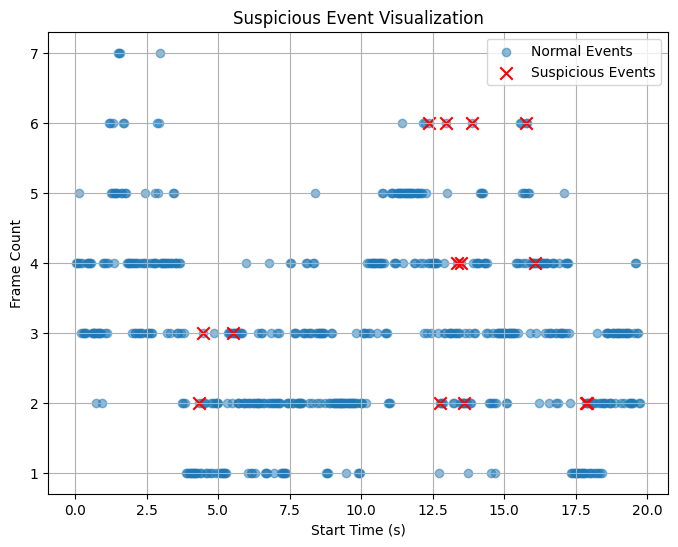

In [9]:
# After pipeline is complete
event_log_file = os.path.join(events_dir, "event_logs.csv")
telemetry_file = os.path.join(events_dir, "telemetry.csv")
alert_file = os.path.join(events_dir, "triggered_alerts.csv")

# Run alert system
analyze_events_and_trigger_alerts(event_log_file, alert_file, telemetry_file)

# (Optional) Show suspicious event plot
plot_suspicious_events(event_log_file)


# Alert System P2 : Safty Alert (Email)

In [10]:
pip install secure-smtplib

Note: you may need to restart the kernel to use updated packages.


In [16]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import pandas as pd
import os

def send_email_alert(alert_file, recipient_email, sender_email, sender_password):
    # Load the alert data
    if not os.path.exists(alert_file):
        print("[⚠️] Alert file does not exist.")
        return
    
    alerts_df = pd.read_csv(alert_file)

    if alerts_df.empty:
        print("[ℹ️] No alerts to send.")
        return

    # Compose a single report
    report_lines = []
    for _, row in alerts_df.iterrows():
        summary = (
            f"Alert for Event ID {row['event_id']}:\n"
            f"Reason: {row['reason']}.\n"
            f"Duration: {row['start_time']}s to {row['end_time']}s"
        )
        report_lines.append(summary)

    report_text = "\n\n".join(report_lines)

    # Email content
    subject = f"[Security Alert] {len(alerts_df)} Suspicious Event(s) Detected"
    body = (
        f"Dear User,\n\n"
        f"The surveillance system has detected {len(alerts_df)} suspicious event(s).\n\n"
        f"Summary of anomalies:\n\n"
        f"{report_text}\n\n"
        f"Regards,\nSecurity Monitoring System"
    )

    # Compose email
    msg = MIMEMultipart()
    msg["From"] = sender_email
    msg["To"] = recipient_email
    msg["Subject"] = subject
    msg.attach(MIMEText(body, "plain"))

    # Print for debugging/logging
    print("------ EMAIL TO BE SENT ------")
    print(f"To      : {recipient_email}")
    print(f"Subject : {subject}")
    print("Body    :\n" + body)
    print("------------------------------")

    try:
        # Connect to Gmail SMTP
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.ehlo()
        server.starttls()
        server.login(sender_email, sender_password)
        server.send_message(msg)
        server.quit()
        print("[📧] Email alert sent successfully.")
    except smtplib.SMTPException as smtp_error:
        print(f"[❌] SMTP Error: {smtp_error}")
    except Exception as e:
        print(f"[❌] Failed to send email: {e}")


In [18]:
alert_file = os.path.join(events_dir, "triggered_alerts.csv")

# Replace with actual values
recipient_email = "harshchinchakar33@gmail.com"
sender_email = "harshchinchakar9921@gmail.com"
sender_password = "gwcgznjlxjsujzwe"  # Gmail App Password (revoked post testing)

send_email_alert(alert_file, recipient_email, sender_email, sender_password)


------ EMAIL TO BE SENT ------
To      : harshchinchakar33@gmail.com
Subject : [Security Alert] 14 Suspicious Event(s) Detected
Body    :
Dear User,

The surveillance system has detected 14 suspicious event(s).

Summary of anomalies:

Alert for Event ID 127:
Reason: Suspicious object detected.
Duration: 4.337666666666667s to 4.337666666666667s

Alert for Event ID 131:
Reason: Suspicious object detected.
Duration: 4.471133333333333s to 4.471133333333333s

Alert for Event ID 159:
Reason: Suspicious object detected.
Duration: 5.5055000000000005s to 5.5055000000000005s

Alert for Event ID 365:
Reason: Suspicious object detected.
Duration: 12.379033333333334s to 12.379033333333334s

Alert for Event ID 376:
Reason: Suspicious object detected.
Duration: 12.746066666666668s to 12.746066666666668s

Alert for Event ID 383:
Reason: Suspicious object detected.
Duration: 12.979633333333334s to 12.979633333333334s

Alert for Event ID 393:
Reason: Suspicious object detected.
Duration: 13.346666666666

# Agentic Chatbot

In [31]:
!pip install streamlit pyngrok groq fpdf matplotlib scikit-learn sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 3.9 MB/s eta 0:00:00


In [40]:
pip install gradio pandas sentence-transformers scikit-learn requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 37.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 107.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


🔐 Drone Security Agentic Chatbot 🚁
Ask anything about today's surveillance. Type 'exit' to quit.

[📊] Generating visualizations...


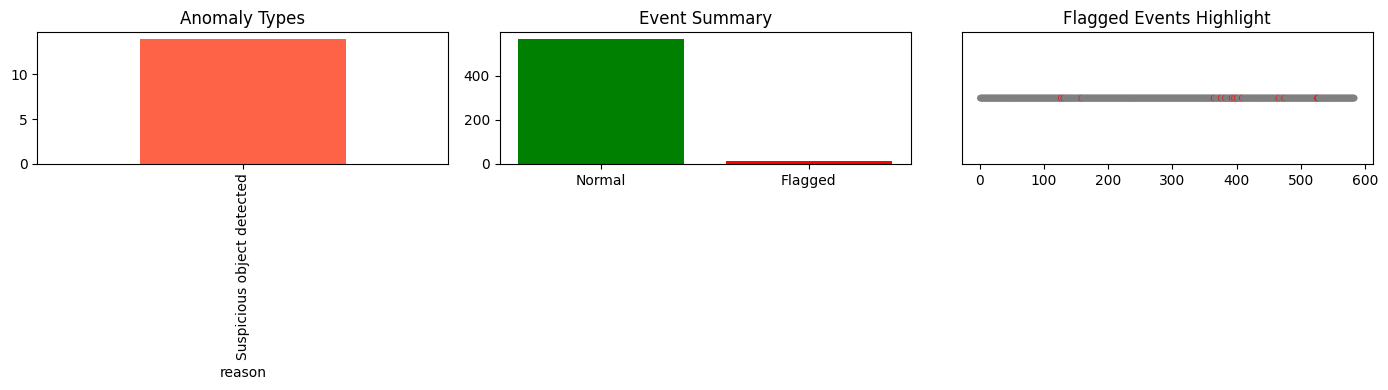


👤 You:  give me todays report in pdf


🤖 Thinking...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🤖 Agent: 
🔍 Event 1:
[🛰️ Event Summary]
- ID: 1
- Caption: Movement detected for car: a parking lot with cars parked in it
- Objects Detected: car
- Frame Count: 4
- Status: Normal
- Reason: Unflagged normal event.

🔍 Event 2:
[🛰️ Event Summary]
- ID: 2
- Caption: Movement detected for car: a parking lot with cars parked in it
- Objects Detected: car
- Frame Count: 4
- Status: Normal
- Reason: Unflagged normal event.

🔍 Event 3:
[🛰️ Event Summary]
- ID: 3
- Caption: Movement detected for car: a parking lot with cars parked in it
- Objects Detected: car
- Frame Count: 4
- Status: Normal
- Reason: Unflagged normal event.

🔍 Event 4:
[🛰️ Event Summary]
- ID: 4
- Caption: Movement detected for car: a parking lot with cars parked in it
- Objects Detected: car
- Frame Count: 5
- Status: Normal
- Reason: Unflagged normal event.

🔍 Event 5:
[🛰️ Event Summary]
- ID: 5
- Caption: Movement detected for car: a parking lot with cars parked in it
- Objects Detected: car
- Frame Count: 4
- Status: N

KeyboardInterrupt: Interrupted by user

In [64]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from datetime import datetime

# Paths
alerts_path = "/kaggle/working/events/triggered_alerts.csv"
event_log_path = "/kaggle/working/events/event_logs.csv"
embeddings_path = "/kaggle/working/events/event_embeddings.json"
chat_log_path = "/kaggle/working/events/chat_log.txt"

# Load data
alerts_df = pd.read_csv(alerts_path)
event_logs_df = pd.read_csv(event_log_path)
with open(embeddings_path, "r") as f:
    embeddings = json.load(f)

# Load embedding model
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Optional GORQ API (disabled in Kaggle) ---
GORQ_API_URL = "https://gorq.ai/api/v1/paraphrase"
GORQ_API_KEY = "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"  

def query_gorq(prompt):
    # Disabled due to no internet in Kaggle
    return "GORQ summarization unavailable in this environment."

# Dual Search (Semantic + Keyword)
def dual_search(query):
    query_emb = semantic_model.encode(query, convert_to_tensor=True).cpu()

    sem_scores = [
        (e["event_id"], float(util.cos_sim(query_emb, torch.tensor(e["embedding"], dtype=torch.float32).unsqueeze(0))[0][0]))
        for e in embeddings
    ]

    kw_scores = []
    for _, row in event_logs_df.iterrows():
        score = sum(word.lower() in row["caption"].lower() for word in query.split())
        if score > 0:
            kw_scores.append((row["event_id"], score))

    top_sem = sorted(sem_scores, key=lambda x: x[1], reverse=True)[:10]
    top_kw = sorted(kw_scores, key=lambda x: x[1], reverse=True)[:10]
    combined = {ev: score for ev, score in top_sem + top_kw}
    top_combined = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:10]
    return list(dict.fromkeys([ev_id for ev_id, _ in top_combined]))


# Get event details (fallback summarization)
def get_event_info(event_id):
    group = event_logs_df[event_logs_df["event_id"] == event_id]
    if group.empty:
        return "No data available for this event."

    row = group.iloc[0]
    related_alert = alerts_df[alerts_df["event_id"] == event_id]
    reason = related_alert["reason"].iloc[0] if not related_alert.empty else "Unflagged normal event."

    caption = row['caption']
    objects = ', '.join(eval(row['objects']))
    frames = row['frame_count']
    
    summary = f"""[🛰️ Event Summary]
- ID: {event_id}
- Caption: {caption}
- Objects Detected: {objects}
- Frame Count: {frames}
- Status: {'Anomaly' if not related_alert.empty else 'Normal'}
- Reason: {reason}"""
    
    return summary

# Chat log utilities
def log_chat(query, response):
    with open(chat_log_path, "a") as f:
        f.write(f"User: {query}\nAgent: {response}\n")

def load_recent_chats(n=3):
    if not os.path.exists(chat_log_path):
        return ""
    with open(chat_log_path, "r") as f:
        lines = f.readlines()
    return "".join(lines[-2*n:])

# Visualization (3 charts)
def generate_visualizations():
    print("\n[📊] Generating visualizations...")

    plt.figure(figsize=(14, 4))

    # 1. Count of flagged anomalies
    plt.subplot(1, 3, 1)
    alerts_df["reason"].value_counts().plot(kind="bar", color="tomato")
    plt.title("Anomaly Types")

    # 2. Flagged vs Unflagged Events
    plt.subplot(1, 3, 2)
    labels = ["Normal", "Flagged"]
    counts = [len(event_logs_df) - len(alerts_df), len(alerts_df)]
    plt.bar(labels, counts, color=["green", "red"])
    plt.title("Event Summary")

    # 3. Highlight flagged events
    plt.subplot(1, 3, 3)
    all_event_ids = event_logs_df["event_id"]
    flagged_ids = alerts_df["event_id"]
    colors = ["red" if eid in flagged_ids.values else "grey" for eid in all_event_ids]
    plt.scatter(all_event_ids, [1]*len(all_event_ids), c=colors, s=15)
    plt.title("Flagged Events Highlight")
    plt.yticks([])

    plt.tight_layout()
    plt.show()

# Main chatbot function
def chatbot():
    print("🔐 Drone Security Agentic Chatbot 🚁")
    print("Ask anything about today's surveillance. Type 'exit' to quit.")
    generate_visualizations()

    while True:
        query = input("\n👤 You: ").strip()
        if query.lower() == "exit":
            print("👋 Exiting chatbot.")
            break

        print("🤖 Thinking...")
        relevant_ids = dual_search(query)
        if not relevant_ids:
            response = "I couldn't find relevant events for your query."
        elif "report" in query.lower():
            report = ""
            for eid in relevant_ids:
                report += f"\n🔍 Event {eid}:\n" + get_event_info(eid) + "\n"
            response = report
        else:
            eid = relevant_ids[0]
            response = get_event_info(eid)

        print(f"\n🤖 Agent: {response}")
        log_chat(query, response)

# Run it
chatbot()


🔐 Drone Security Agentic Chatbot 🚁
Ask anything about today's surveillance. Type 'exit' to quit.

[📊] Generating visualizations...


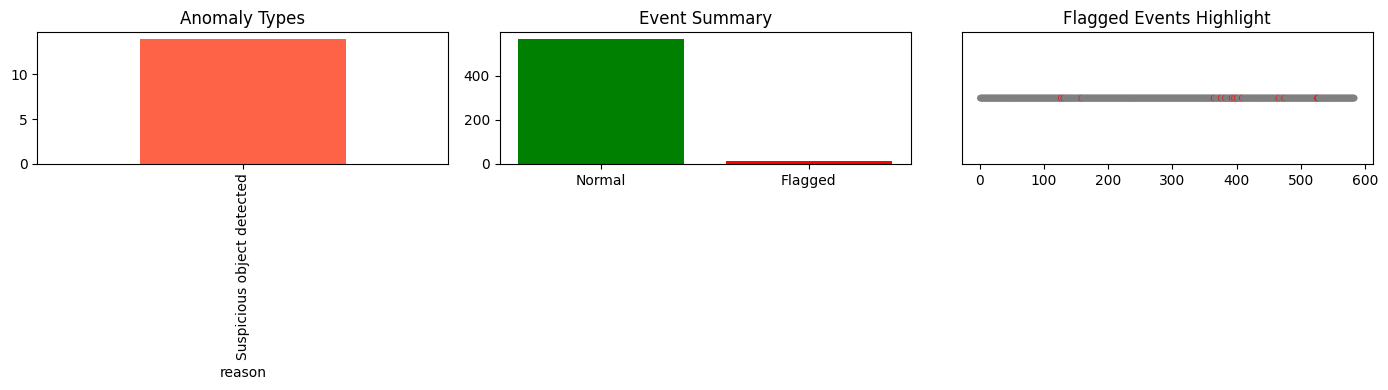


👤 You:  hey


🤖 Thinking...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🤖 Agent: [🛰️ Event Summary]
- ID: 505
- Caption: Movement detected for truck, car: a parking lot with cars parked in it
- Objects Detected: truck, car
- Frame Count: 5
- Status: Normal
- Reason: Unflagged normal event.



👤 You:  give me the report


🤖 Thinking...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🤖 Agent: 📄 Report has been generated and mailed to you.



👤 You:  exit


👋 Exiting chatbot.


In [65]:


import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from datetime import datetime
from fpdf import FPDF
import smtplib
from email.message import EmailMessage

# Paths
alerts_path = "/kaggle/working/events/triggered_alerts.csv"
event_log_path = "/kaggle/working/events/event_logs.csv"
embeddings_path = "/kaggle/working/events/event_embeddings.json"
chat_log_path = "/kaggle/working/events/chat_log.txt"

# Load data
alerts_df = pd.read_csv(alerts_path)
event_logs_df = pd.read_csv(event_log_path)
with open(embeddings_path, "r") as f:
    embeddings = json.load(f)

# Load embedding model
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Optional GORQ API (disabled in Kaggle) ---
GORQ_API_URL = "https://gorq.ai/api/v1/paraphrase"
GORQ_API_KEY = "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"  



def generate_pdf_report(event_ids, file_path="/kaggle/working/events/daily_report.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Daily Drone Surveillance Report", ln=True, align="C")
    pdf.ln(10)

    for eid in event_ids:
        group = event_logs_df[event_logs_df["event_id"] == eid]
        if group.empty:
            continue
        row = group.iloc[0]
        caption = row['caption']
        objects = ', '.join(eval(row['objects']))
        frame_count = row['frame_count']
        related_alert = alerts_df[alerts_df["event_id"] == eid]
        reason = related_alert["reason"].iloc[0] if not related_alert.empty else "Unflagged normal event."

        pdf.multi_cell(0, 10, f"Event ID: {eid}\nCaption: {caption}\nObjects: {objects}\nFrames: {frame_count}\nReason: {reason}\n", border=1)
        pdf.ln(5)

    pdf.output(file_path)
    return file_path

def send_email_alert(attachment_path, recipient_email, sender_email, sender_password):
    msg = EmailMessage()
    msg["Subject"] = "Drone Surveillance Report"
    msg["From"] = sender_email
    msg["To"] = recipient_email
    msg.set_content("Attached is your requested drone surveillance report.")

    with open(attachment_path, "rb") as f:
        file_data = f.read()
        file_name = os.path.basename(attachment_path)
        msg.add_attachment(file_data, maintype="application", subtype="pdf", filename=file_name)

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
        smtp.login(sender_email, sender_password)
        smtp.send_message(msg)



def query_gorq(prompt):
    # Disabled due to no internet in Kaggle
    return "GORQ summarization unavailable in this environment."

# Dual Search (Semantic + Keyword)
def dual_search(query):
    query_emb = semantic_model.encode(query, convert_to_tensor=True).cpu()

    sem_scores = [
        (e["event_id"], float(util.cos_sim(query_emb, torch.tensor(e["embedding"], dtype=torch.float32).unsqueeze(0))[0][0]))
        for e in embeddings
    ]

    kw_scores = []
    for _, row in event_logs_df.iterrows():
        score = sum(word.lower() in row["caption"].lower() for word in query.split())
        if score > 0:
            kw_scores.append((row["event_id"], score))

    top_sem = sorted(sem_scores, key=lambda x: x[1], reverse=True)[:10]
    top_kw = sorted(kw_scores, key=lambda x: x[1], reverse=True)[:10]
    combined = {ev: score for ev, score in top_sem + top_kw}
    top_combined = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:10]
    return list(dict.fromkeys([ev_id for ev_id, _ in top_combined]))


# Get event details (fallback summarization)
def get_event_info(event_id):
    group = event_logs_df[event_logs_df["event_id"] == event_id]
    if group.empty:
        return "No data available for this event."

    row = group.iloc[0]
    related_alert = alerts_df[alerts_df["event_id"] == event_id]
    reason = related_alert["reason"].iloc[0] if not related_alert.empty else "Unflagged normal event."

    caption = row['caption']
    objects = ', '.join(eval(row['objects']))
    frames = row['frame_count']
    
    summary = f"""[🛰️ Event Summary]
- ID: {event_id}
- Caption: {caption}
- Objects Detected: {objects}
- Frame Count: {frames}
- Status: {'Anomaly' if not related_alert.empty else 'Normal'}
- Reason: {reason}"""
    
    return summary

# Chat log utilities
def log_chat(query, response):
    with open(chat_log_path, "a") as f:
        f.write(f"User: {query}\nAgent: {response}\n")

def load_recent_chats(n=3):
    if not os.path.exists(chat_log_path):
        return ""
    with open(chat_log_path, "r") as f:
        lines = f.readlines()
    return "".join(lines[-2*n:])

# Visualization (3 charts)
def generate_visualizations():
    print("\n[📊] Generating visualizations...")

    plt.figure(figsize=(14, 4))

    # 1. Count of flagged anomalies
    plt.subplot(1, 3, 1)
    alerts_df["reason"].value_counts().plot(kind="bar", color="tomato")
    plt.title("Anomaly Types")

    # 2. Flagged vs Unflagged Events
    plt.subplot(1, 3, 2)
    labels = ["Normal", "Flagged"]
    counts = [len(event_logs_df) - len(alerts_df), len(alerts_df)]
    plt.bar(labels, counts, color=["green", "red"])
    plt.title("Event Summary")

    # 3. Highlight flagged events
    plt.subplot(1, 3, 3)
    all_event_ids = event_logs_df["event_id"]
    flagged_ids = alerts_df["event_id"]
    colors = ["red" if eid in flagged_ids.values else "grey" for eid in all_event_ids]
    plt.scatter(all_event_ids, [1]*len(all_event_ids), c=colors, s=15)
    plt.title("Flagged Events Highlight")
    plt.yticks([])

    plt.tight_layout()
    plt.show()

# Main chatbot function
def chatbot():
    print("🔐 Drone Security Agentic Chatbot 🚁")
    print("Ask anything about today's surveillance. Type 'exit' to quit.")
    generate_visualizations()

    while True:
        query = input("\n👤 You: ").strip()
        if query.lower() == "exit":
            print("👋 Exiting chatbot.")
            break

        print("🤖 Thinking...")
        relevant_ids = dual_search(query)
        if not relevant_ids:
            response = "I couldn't find relevant events for your query."
        elif "report" in query.lower():
            report = ""
            for eid in relevant_ids:
                report += f"\n🔍 Event {eid}:\n" + get_event_info(eid) + "\n"

            # Generate PDF and email
            pdf_path = generate_pdf_report(relevant_ids)
            send_email_alert(
                attachment_path=pdf_path,
                recipient_email="harshchinchakar33@gmail.com",
                sender_email="harshchinchakar9921@gmail.com",
                sender_password="gwcgznjlxjsujzwe"
            )
            response = "📄 Report has been generated and mailed to you."
        
        else:
            eid = relevant_ids[0]
            response = get_event_info(eid)

        print(f"\n🤖 Agent: {response}")
        log_chat(query, response)

# Run it
chatbot()


In [69]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from datetime import datetime
from fpdf import FPDF
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import torch
from groq import Groq
import ast

# Paths
alerts_path = "/kaggle/working/events/triggered_alerts.csv"
event_log_path = "/kaggle/working/events/event_logs.csv"
embeddings_path = "/kaggle/working/events/event_embeddings.json"
chat_log_path = "/kaggle/working/events/chat_log.txt"
pdf_report_path = "/kaggle/working/events/security_report.pdf"
plot_path = "/kaggle/working/events/visual_summary.png"

# Email credentials
recipient_email = "harshchinchakar33@gmail.com"
sender_email = "harshchinchakar9921@gmail.com"
sender_password = "gwcgznjlxjsujzwe"  # Gmail App Password

# Load data
alerts_df = pd.read_csv(alerts_path)
event_logs_df = pd.read_csv(event_log_path)
with open(embeddings_path, "r") as f:
    embeddings = json.load(f)

# Load embedding model
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

# GROQ API
GROQ_API_KEY = "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"
client = Groq(api_key=GROQ_API_KEY)

def query_groq(prompt, chat_history=""):
    try:
        chat_completion = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[
                {"role": "system", "content": "You are a Drone Security Analyst Assistant."},
                {"role": "user", "content": chat_history},
                {"role": "user", "content": prompt}
            ],
        )
        return chat_completion.choices[0].message.content
    except Exception as e:
        return f"GROQ error: {e}"

def dual_search(query):
    query_emb = semantic_model.encode(query, convert_to_tensor=True).cpu().type(torch.float32)
    sem_scores = [(e["event_id"], float(util.cos_sim(query_emb, torch.tensor(e["embedding"]).type(torch.float32))[0])) for e in embeddings]
    
    kw_scores = []
    for _, row in event_logs_df.iterrows():
        score = sum(word.lower() in row["caption"].lower() for word in query.split())
        if score > 0:
            kw_scores.append((row["event_id"], score))

    top_sem = sorted(sem_scores, key=lambda x: x[1], reverse=True)[:10]
    top_kw = sorted(kw_scores, key=lambda x: x[1], reverse=True)[:10]
    combined = {ev: score for ev, score in top_sem + top_kw}
    top_combined = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:10]
    return list(dict.fromkeys([ev_id for ev_id, _ in top_combined]))

def log_chat(query, response):
    with open(chat_log_path, "a") as f:
        f.write(f"User: {query}\nAgent: {response}\n")

def load_recent_chats(n=3):
    if not os.path.exists(chat_log_path):
        return ""
    with open(chat_log_path, "r") as f:
        lines = f.readlines()
    return "".join(lines[-2*n:])

def generate_visualizations():
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    alerts_df["reason"].value_counts().plot(kind="bar", color="tomato")
    plt.title("Anomaly Types")

    plt.subplot(1, 3, 2)
    labels = ["Normal", "Flagged"]
    counts = [len(event_logs_df) - len(alerts_df), len(alerts_df)]
    plt.bar(labels, counts, color=["green", "red"])
    plt.title("Event Summary")

    plt.subplot(1, 3, 3)
    all_event_ids = event_logs_df["event_id"]
    flagged_ids = alerts_df["event_id"]
    colors = ["red" if eid in flagged_ids.values else "grey" for eid in all_event_ids]
    plt.scatter(all_event_ids, [1]*len(all_event_ids), c=colors, s=15)
    plt.title("Flagged Events Highlight")
    plt.yticks([])

    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()

def send_email_alert(pdf_path, to_email, from_email, password):
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = "Drone Surveillance Report"

    part = MIMEBase('application', "octet-stream")
    with open(pdf_path, "rb") as file:
        part.set_payload(file.read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', f'attachment; filename="{os.path.basename(pdf_path)}"')
    msg.attach(part)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    server.login(from_email, password)
    server.send_message(msg)
    server.quit()

def generate_pdf_report():
    generate_visualizations()

    all_captions = event_logs_df['caption'].value_counts()
    unique_captions = list(all_captions.index)
    counts = list(all_captions.values)

    combined_summary = "\n".join([f"{cap} (x{cnt})" for cap, cnt in zip(unique_captions, counts)])
    chat_history = load_recent_chats()
    summary_prompt = (
        f"The following are drone surveillance event captions observed today. Remove redundancy (merge repeating ones) and summarize the key happenings.\n"
        f"Format output as a short paragraph for a professional report.\n\n{combined_summary}"
    )
    summary = query_groq(summary_prompt, chat_history)

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 10, f"Drone Surveillance Report\n\nSummary:\n{summary}\n")

    pdf.ln(5)
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Event Metrics", ln=True)
    pdf.set_font("Arial", size=11)
    pdf.cell(0, 10, f"Total Events: {len(event_logs_df)}", ln=True)
    pdf.cell(0, 10, f"Flagged Events: {len(alerts_df)}", ln=True)
    pdf.cell(0, 10, f"Normal Events: {len(event_logs_df) - len(alerts_df)}", ln=True)
    pdf.cell(0, 10, f"Flag Reasons: {', '.join(alerts_df['reason'].value_counts().index)}", ln=True)

    pdf.image(plot_path, x=10, y=None, w=180)
    pdf.output(pdf_report_path)
    send_email_alert(pdf_report_path, recipient_email, sender_email, sender_password)

# Main chatbot loop
print("🔐 Drone Security Agentic Chatbot 🚁")
print("Ask anything about today's surveillance. Type 'exit' to quit.")

generate_visualizations()

while True:
    query = input("\n👤 You: ").strip()
    if query.lower() == "exit":
        print("👋 Exiting chatbot.")
        break

    print("🤖 Thinking...")
    relevant_ids = dual_search(query)

    if "report" in query.lower():
        generate_pdf_report()
        response = "📨 Report generated and emailed successfully."
    elif not relevant_ids:
        response = query_groq(query)
        response += "\n\n🔁 Redirecting back to event overview. Today's surveillance involved multiple flagged and normal events. Ask to generate report or inquire about security triggers."
    else:
        eid = relevant_ids[0]
        row = event_logs_df[event_logs_df["event_id"] == eid].iloc[0]
        reason = alerts_df[alerts_df["event_id"] == eid]["reason"].iloc[0] if not alerts_df[alerts_df["event_id"] == eid].empty else "Normal activity."
        prompt = f"Summarize the following drone surveillance event:\nCaption: {row['caption']}\nObjects: {', '.join(ast.literal_eval(row['objects']))}\nFrame Count: {row['frame_count']}\nReason: {reason}"
        chat_history = load_recent_chats()
        response = query_groq(prompt, chat_history)

    print(f"\n🤖 Agent: {response}")
    log_chat(query, response)


🔐 Drone Security Agentic Chatbot 🚁
Ask anything about today's surveillance. Type 'exit' to quit.



👤 You:  hey, how was today


🤖 Thinking...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🤖 Agent: Here is a summary of the drone surveillance event:

**Event Summary:**

* **Location:** A parking lot with multiple cars parked
* **Objects detected:** A bench and a car
* **Frame Count:** 2 frames of video footage
* **Reason for Alert:** A suspicious object was detected, triggering the movement alert.

**Analysis:**

The drone's surveillance system has detected movement in a parking lot, specifically a bench and a car. The system has flagged this as a suspicious object detection, which may require further investigation to determine the nature of the movement and ensure security protocols are in place.



👤 You:  great, i want the complete report


🤖 Thinking...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🤖 Agent: 📨 Report generated and emailed successfully.



👤 You:  there was alot of traffic today


🤖 Thinking...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🤖 Agent: **Event Summary:**

The drone's surveillance system has detected movement in a parking lot, specifically a truck and a car. However, the system has classified this event as "Normal Activity" and therefore does not require further investigation. The event has been flagged as non-suspicious and does not pose a security threat.



👤 You:  exit


👋 Exiting chatbot.
